In [48]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns
import seaborn.objects as so

sns.set_theme()

# Assignment 4
**Julien ARS** - 07.01.2024

## Task 1 : Natural frequency

We make the following assumptions :
1. We will analyse the bridge under longitudinal flexion
1. We consider that the liaison between the HEM140 on the middle of the bridge is such that it can be considered as a full length HEM140 beam in the longitudinal axis.
1. Any other element than the HEM140 do not have any structural influence on the behaviour of the bridge (considering the connection consisting of 4 bolts is not sufficient to have them take any effort in their secondary axis), except for their weight. In particular, this means we can consider :
$$ EI = \text{const} = 2*EI_{HEM140} $$
4. We modelise the bridge as a beam on two supports, one of which is mobile
5. The weight of the cord is neglectable

Properties of the different elements, as well as of the bridge, are taken from the C5  table.

In order to estimate the natural frequency, we will start with reducing the footbridge as a SDOF system, using the method provided [*Systems with distributed mass*, Aline Bönzli].

In order to do so, we will modelise the mass of the bridge and it's rigidity in python : (using a precision to the milimeter for the computation)

In [19]:
# Properties of steel :
E = 210e3 #N/mm²
rho = 7850 #kg/m³

# Rigidity :
EI = 2 * E * (32.9e6) #N.mm²

In [31]:
# Define coordinates :
# -  x : longitudinal axis (0 at first appui)
x = np.linspace(-300, 10300, 10601)
dx = x[1]-x[0] # mm
# Lambda utility to get the indice from a position:
i = lambda xi : np.argmin(np.abs(x-xi))  # noqa: E731

# Define empty mass array (in x coordinatess)
m = np.zeros(10601) #kg/mm

print(x, dx, m , i(5000), sep="  -  ")

[ -300.  -299.  -298. ... 10298. 10299. 10300.]  -  1.0  -  [0. 0. 0. ... 0. 0. 0.]  -  5300


In [36]:
# Fill the mass array :

## Longitudinal constant weight : 2*HEM140 + plates of 40 mm x 1m
m[:] = 2*63.2e-3 + (40e-3 * 1 * 1e-3) * rho # kg/mm 

## Transversal elements weight gets transfered to the HEM beams only at the location of the bolts
## Therefore, we will add them as point masses at the center of the bolt
## The transversal elements consist each time of : 
#   - 1* HEA100 x 783 mm
m_HEA100 = 16.7 * 0.783 #kg
#   - 4*FLA 90.20 L=110mm
m_FLA = 14.1 * 0.110 #kg
#   - 2*IPET 180 L=155mm(however, cut in triangle with a triangle of 50x155mm removed)
m_IPE180 = 9.40 *0.155 - (0.050 * 0.155 * 0.0053)/2 * rho #kg
#   - 2*ROR 51.5.0 L=1330 mm
m_ROR = 5.67 * 1.33 #kg
#   - 2*tubes dint=35mm, dext=38mm, L=50mm
m_tubes = (np.pi * (19e-3**2 - 17.5e-3**2) * 50e-3) * rho #kg
#   - 2*rondelles
m_rondelles = (np.pi * 27e-3**2 * 6e-3) * rho #kg

m_transversal = 1*m_HEA100 + 4*m_FLA + 2*m_IPE180 + 2*m_ROR + 2*m_tubes + 2*m_rondelles

print(m_transversal, m_HEA100, m_FLA, m_IPE180, m_ROR, m_tubes, m_rondelles)

# These transveral elements are present at 6 locations :
x_trans = np.array([0, 2000, 4000, 6000, 8000, 10000]) #mm

# Bolts are present 30 mm from those locations
x_bolts = np.concatenate((x_trans-30, x_trans+30))
print(x_bolts)

# Add the mass from the transversal elements :
m[[i(x) for x in x_bolts]] += m_transversal / 2 / dx #dividing by dx ensures the mass is fully considered, even for dx != 1

37.276328321797656 13.0761 1.551 1.456838780625 7.5411 6.751086263023609e-05 0.00010786941119439377
[  -30  1970  3970  5970  7970  9970    30  2030  4030  6030  8030 10030]


c:\Users\arsju\anaconda3\envs\Basic\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


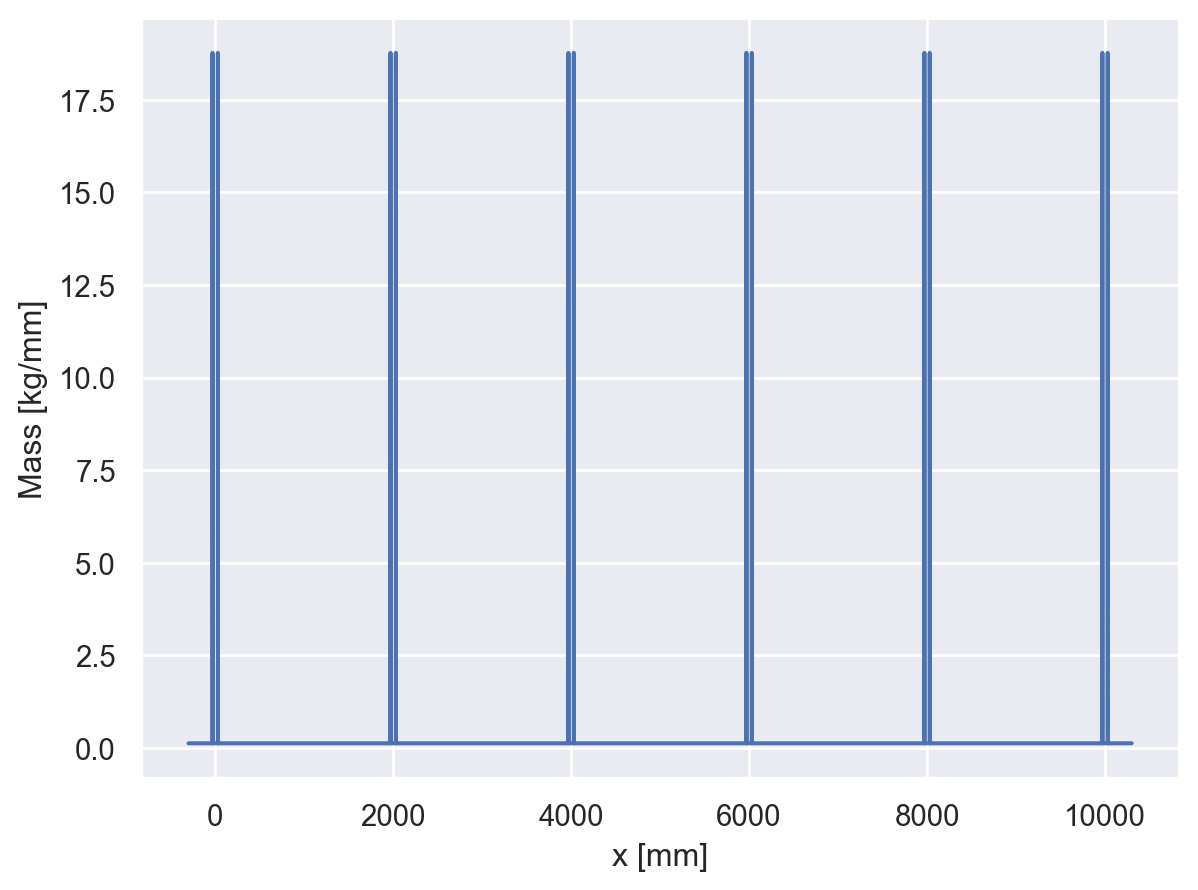

In [46]:
(
    so.Plot(x=x, y=m)
    .add(so.Line())
    .label(x="x [mm]", y="Mass [kg/mm]")
    .plot()
)

Now that we have the mass, we need to define the bending shape. We will opt for a sine function, which will be equal to 0 at each support ($x = 0 $ and $x = 10000$ [mm]). We consider that outside the supports, the beam will also deform in a sin shape.
$$ \psi(x) = \text{sin}(\frac{x*\pi}{10 \text{ m}}) $$
Which yields :
$$ \psi''(x) = \psi(x) * \left (\frac{\pi}{10 \text{ m}} \right )^2

In [66]:
psi = np.sin(x*np.pi/10000)
psi_pp = psi * (np.pi/10000)**2 # -/mm²

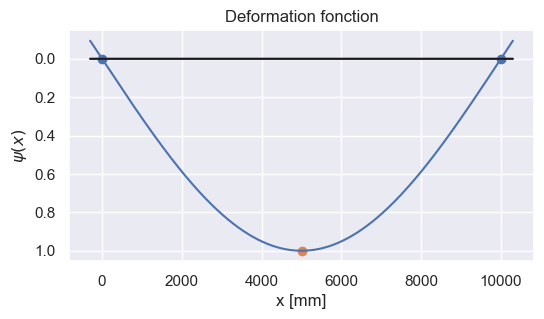

In [71]:
plt.figure(figsize=(6, 3))
plt.plot(x, psi)
plt.plot(x, np.zeros_like(x), c="k")
plt.scatter([0, 10000], [0,0])
plt.scatter(x[i(5000)], psi[i(5000)])
plt.gca().invert_yaxis()
plt.title("Deformation fonction")
plt.xlabel("x [mm]")
plt.ylabel("$\psi(x)$")

plt.show()

**Equivalent mass and stiffness**

Now, we might compute the equivalent mass $m^{*}$ and stiffness $k^{*}$:

$$ m^{*} = \int_{0}^{L} m(x) * \psi^2(x) \text{ d}x $$
$$ k^{*} = \int_{0}^{L} EI * \psi''^2(x) \text{ d}x $$

(considering there are no normal force in the beam)